# Capstone Three: Data Wrangling and EDA

Currently, pathologists manually classify blood cells, which is time-consuming and prone to human error. Artificial Intelligence could speed up this process, leading to faster disease diagnosis. Blood cell classification is important because it plays a key role in medical diagnosis, treatment planning, and disease monitoring. Blood cell abnormalities are linked to serious conditions such as: Leukemia, Anemia, Infections, etc. Hospitals and labs handle thousands of samples daily. Automating this process could reduce operational costs through cutting down labor intensive manual work. By developing a model for blood cell classification, we could improve medical efficiency, enhance patient care, and increase hospital/lab efficiency. This portion of the project will focus on wrangling the blood cell data and exploratory data analysis of the blood cell images in our dataset.

## Imports

In [4]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates
import seaborn as sns
from skimage.filters import gabor
import pickle
import math
from scipy.ndimage import gaussian_filter, map_coordinates

2025-03-06 19:53:58.077378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading blood cell images and annotations

In [6]:
def iterate_and_load_images(directory):
    images = []
    for filename in os.listdir(directory):
        # Only process files that are images (png, jpg, jpeg)
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path)
            image = np.array(image)  # Convert image to NumPy array
            images.append(image)
    return images

# Path to your images folder
IMAGE_DIR = "BCC_data/images"

# Load all images from the directory
all_images = iterate_and_load_images(IMAGE_DIR)

In [7]:
df = pd.read_csv("BCC_data/labels.csv")

In [8]:
df["image"] = df["image"].apply(lambda x: os.path.join(IMAGE_DIR, x))

In [9]:
df.head()

,image,label
0,BCC_data/images/image-1.png,wbc
1,BCC_data/images/image-2.png,wbc
2,BCC_data/images/image-4.png,wbc
3,BCC_data/images/image-7.png,wbc
4,BCC_data/images/image-8.png,wbc


In [10]:
df['label'].value_counts()

label
rbc    51
wbc    49
Name: count, dtype: int64

## Plotting images

In [12]:
def plot_images(images, titles=None, suptitle=None, overlay=False, colorbar='default'):
    num_images = len(images)

    if overlay:
        fig, ax = plt.subplots()
        for image in images:
            ax.imshow(image)
        if colorbar != None:
          fig.colorbar(ax.imshow(image))
        if suptitle:
            plt.suptitle(suptitle)
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
        if num_images == 1:
            axes = [axes]
        for i, image in enumerate(images):
            axes[i].imshow(image)
            if titles:
                axes[i].set_title(titles[i])
            if colorbar == 'multi' and not (image.ndim == 3 and image.shape[2] == 3):
                fig.colorbar(axes[i].imshow(image), ax=axes[i])
            elif colorbar == 'single' and not (image.ndim == 3 and image.shape[2] == 3):
               fig.colorbar(axes[i].imshow(image), ax=axes)
        if suptitle:
            plt.suptitle(suptitle)
    plt.show()

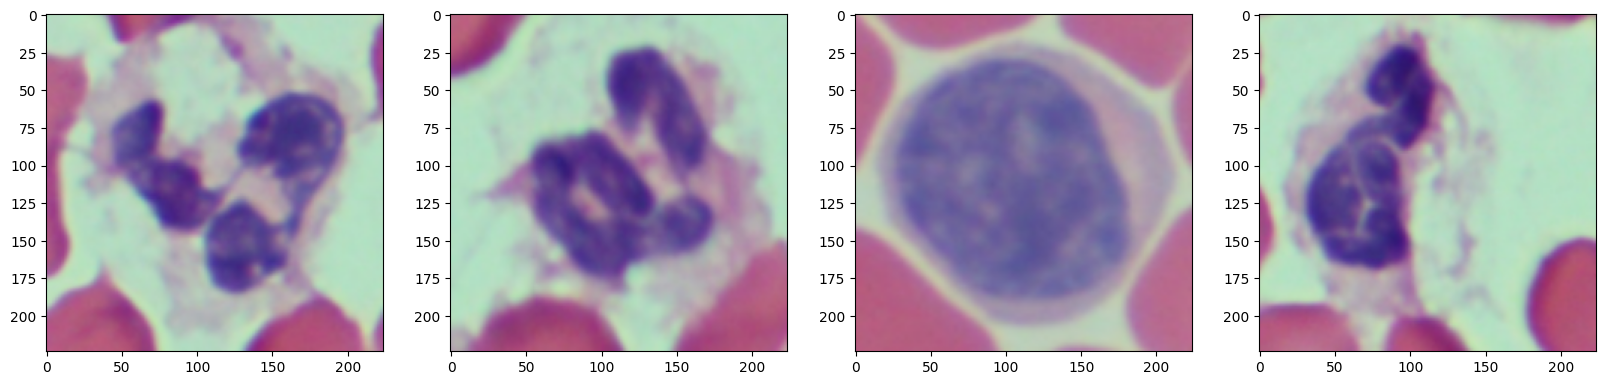

In [13]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[0:4]]
plot_images(get_images)

In [14]:
df['image'].value_counts()

image
BCC_data/images/image-1.png      1
BCC_data/images/image-83.png     1
BCC_data/images/image-93.png     1
BCC_data/images/image-92.png     1
BCC_data/images/image-91.png     1
                                ..
BCC_data/images/image-44.png     1
BCC_data/images/image-43.png     1
BCC_data/images/image-39.png     1
BCC_data/images/image-38.png     1
BCC_data/images/image-120.png    1
Name: count, Length: 100, dtype: int64

Before data any data augmentation we will need to resize the images to 224 x 224 for future use in the modeling portion of the project

In [16]:
image_paths = df['image']
for img_path in image_paths:
    # Ensure the path exists
    if os.path.exists(img_path):
        # Read the image using OpenCV
        image = cv2.imread(img_path)
        img_resized = cv2.resize(image, (224, 224))
        cv2.imwrite(img_path, img_resized)

## Preliminary Data Augmentation

We will be applying an unsharp masking technqiue to the images to enhance edges by subtracting a blurred version of the image from the original, making edges more prominent.

In [19]:
def unsharp_mask(image, sigma=0.8, strength=2.5):
    """Apply unsharp masking to sharpen an image."""
    # Convert to float32 for precision
    image = image.astype(np.float32)

    # Gaussian blur the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)

    # Compute the sharpened image
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)

    # Clip values to ensure they remain in valid range
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened

In [20]:
transformed_images = []

for img_path in image_paths:
    if os.path.exists(img_path):
        # Read the image using OpenCV and convert to RGB
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Loads as BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply elastic deformation
        transformed_image = unsharp_mask(image, sigma=1.0, strength=1.5)
        transformed_images.append(transformed_image)

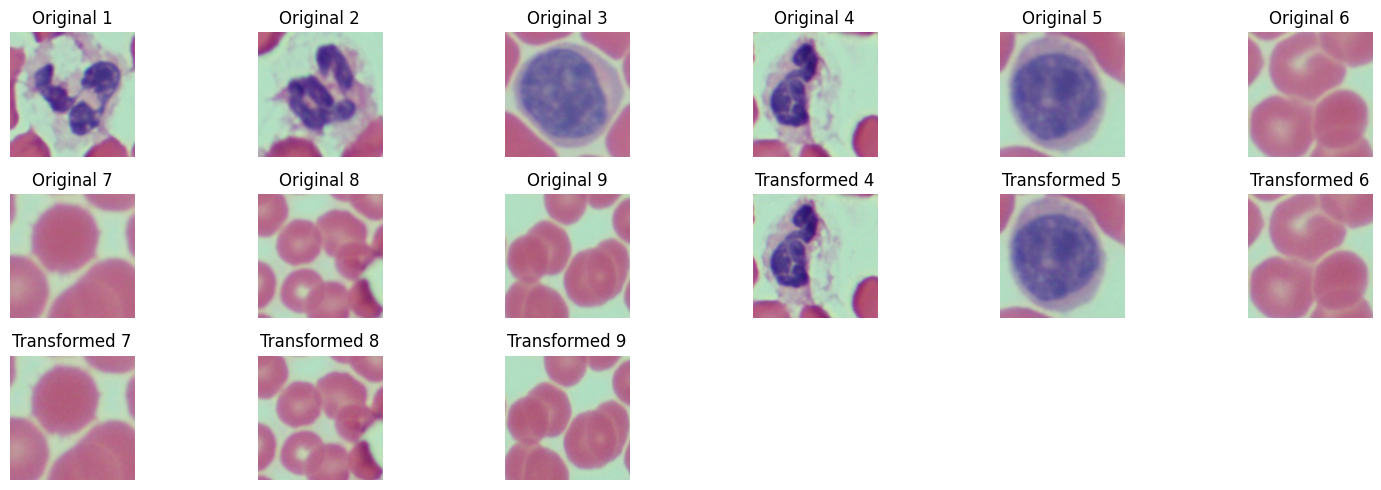

In [21]:
# Display the original and transformed images
plt.figure(figsize=(15, 5))
for i, (orig_img, transformed_img) in enumerate(zip(image_paths[:9], transformed_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(orig_img), cv2.COLOR_BGR2RGB))  # Ensure correct RGB display
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(3, 6, i + 7)
    plt.imshow(transformed_img)
    plt.title(f"Transformed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

We can see that there are a few more red blood cells accounted for than white blood cells. This dataset seems to be overall a balanced dataset.

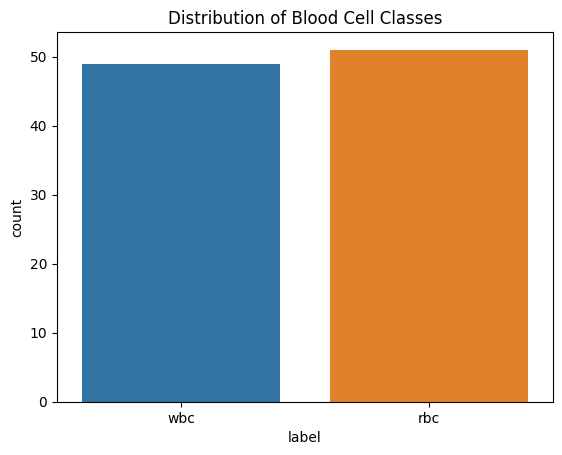

In [24]:
sns.countplot(x='label', data=df) 
plt.title('Distribution of Blood Cell Classes')
plt.show()

In [25]:
print(f"Original Image Size: {image.shape}")
print(f"Transformed Image Size: {transformed_image.shape}")

Original Image Size: (224, 224, 3)
Transformed Image Size: (224, 224, 3)


The images still maintained the same aspect ratio and size. This will be important for our model later, which will expect input images to have the same size.

## Summary

The dataset had a small amount of blood cell images that needed data augmentation to increase robustness of the model.  This will be dealt with in the preprocessing phase with brightening, cropping, etc. of all classes of images. The images contain red and white blood cells. Unsharp masking techniques were applied to sharpen the edges of the blood cells. These transformed images will be the ones used in the next steps of the project. 

In [29]:
with open("transformed_images.pkl", "wb") as f:
    pickle.dump(transformed_images, f)

print("Images saved as transformed_images.pkl")

Images saved as transformed_images.pkl


In [30]:
output_folder = "transformed_images"
os.makedirs(output_folder, exist_ok=True)

# Assuming you have a list of original image paths or names
original_image_paths = df['image'].tolist()  # Adjust if your original image paths are elsewhere

# Ensure the number of transformed images matches the number of original images
for i, (original_path, img) in enumerate(zip(original_image_paths, transformed_images)):
    # Extract the base name of the original image (e.g., 'image_1.png')
    original_image_name = os.path.basename(original_path)
    
    # If the transformed image is a PIL image, convert it to a NumPy array
    if isinstance(img, Image.Image):
        img = np.array(img)  # Convert to NumPy array

    # If the image is in RGB (common in PIL), convert it to BGR for OpenCV
    if img.shape[-1] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Modify the file path to save the transformed image (you can add a suffix to denote it's transformed)
    file_path = os.path.join(output_folder, original_image_name)
    
    # Save the transformed image
    cv2.imwrite(file_path, img)

print(f"Saved {len(transformed_images)} images in '{output_folder}/'")


Saved 100 images in 'transformed_images/'


In [31]:
df.to_csv('annotations2.csv', index=False)

In [32]:
IMAGE_DIR = "transformed_images/"

In [33]:
df = pd.read_csv("annotations2.csv")

In [34]:
df["image"] = df["image"].apply(lambda x: os.path.join(IMAGE_DIR, x))

In [35]:
df["image"] = df["image"].str.replace('BCC_data/images/', '', regex=False)

In [36]:
df.head()

,image,label
0,transformed_images/image-1.png,wbc
1,transformed_images/image-2.png,wbc
2,transformed_images/image-4.png,wbc
3,transformed_images/image-7.png,wbc
4,transformed_images/image-8.png,wbc


In [37]:
df.to_csv('annotations3.csv', index=False)

In [38]:
df.shape

(100, 2)